In [3]:
# NYC Yellow Taxi Trip Analysis - Delivery Route Assistant
# Cognizant Assignment Solution

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb

# Graph libraries for bonus section
import networkx as nx
from scipy.spatial.distance import pdist, squareform

# Set styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

# =============================================================================
# DATA LOADING AND INITIAL PREPROCESSING
# =============================================================================

def load_and_clean_data(file_path=None):
    """
    Load the NYC taxi data and perform initial cleaning
    If no file_path provided, create sample data for demonstration
    """
    print("Loading data...")
    
    if file_path and file_path != 'demo':
        # Load data from file
        try:
            df = pd.read_csv(file_path)
        except FileNotFoundError:
            print(f"File {file_path} not found. Creating sample data for demonstration...")
            df = create_sample_data()
    else:
        # Create sample data for demonstration
        print("Creating sample data for demonstration...")
        df = create_sample_data()
    
    print(f"\nInitial data shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    # Display first few rows
    print("\nFirst 5 rows:")
    print(df.head())
    
    # Basic info
    print("\nData Info:")
    print(df.info())

    # Null values check
    print("\nNull Values Check:")
    null_counts = df.isnull().sum()
    print(null_counts[null_counts > 0] if null_counts.sum() > 0 else "No null values found.")
    
    return df

def create_sample_data(n_samples=1000):
    """
    Create sample NYC taxi data for demonstration purposes
    """
    np.random.seed(42)  # For reproducibility
    
    # Generate sample data
    data = {
        'VendorID': np.random.choice([1, 2], n_samples),
        'tpep_pickup_datetime': pd.date_range('2023-01-01', periods=n_samples, freq='H'),
        'tpep_dropoff_datetime': None,  # Will calculate based on trip duration
        'passenger_count': np.random.choice([1, 2, 3, 4, 5], n_samples, p=[0.4, 0.3, 0.15, 0.1, 0.05]),
        'trip_distance': np.random.exponential(3, n_samples),  # Exponential distribution for distance
        'RatecodeID': np.random.choice([1, 2, 3, 4, 5], n_samples, p=[0.8, 0.1, 0.05, 0.03, 0.02]),
        'store_and_fwd_flag': np.random.choice(['Y', 'N'], n_samples, p=[0.1, 0.9]),
        'PULocationID': np.random.randint(1, 265, n_samples),
        'DOLocationID': np.random.randint(1, 265, n_samples),
        'payment_type': np.random.choice([1, 2, 3, 4], n_samples, p=[0.6, 0.3, 0.08, 0.02]),
        'fare_amount': None,  # Will calculate based on distance
        'extra': np.random.choice([0, 0.5, 1.0], n_samples, p=[0.7, 0.25, 0.05]),
        'mta_tax': 0.5,
        'tip_amount': None,  # Will calculate based on fare
        'tolls_amount': np.random.exponential(0.5, n_samples),
        'improvement_surcharge': 0.3,
        'total_amount': None,  # Will calculate
        'congestion_surcharge': np.random.choice([0, 2.5], n_samples, p=[0.6, 0.4]),
        'airport_fee': np.random.choice([0, 1.25], n_samples, p=[0.9, 0.1])
    }
    
    df = pd.DataFrame(data)
    
    # Calculate derived fields
    # Trip duration (5-120 minutes, correlated with distance)
    base_duration = 5 + df['trip_distance'] * 2 + np.random.normal(0, 5, n_samples)
    base_duration = np.clip(base_duration, 1, 120)  # Clip to reasonable range
    
    df['tpep_dropoff_datetime'] = df['tpep_pickup_datetime'] + pd.to_timedelta(base_duration, unit='minutes')
    
    # Fare amount (base rate + distance rate)
    df['fare_amount'] = 3.0 + df['trip_distance'] * 2.5 + np.random.normal(0, 2, n_samples)
    df['fare_amount'] = np.clip(df['fare_amount'], 3.0, 200.0)
    
    # Tip amount (percentage of fare with some randomness)
    tip_rate = np.random.beta(2, 5, n_samples) * 0.3  # 0-30% tip rate
    df['tip_amount'] = df['fare_amount'] * tip_rate
    
    # Total amount
    df['total_amount'] = (df['fare_amount'] + df['extra'] + df['mta_tax'] + 
                         df['tip_amount'] + df['tolls_amount'] + df['improvement_surcharge'] + 
                         df['congestion_surcharge'] + df['airport_fee'])
    
    # Clean up negative values
    numeric_cols = ['trip_distance', 'fare_amount', 'tip_amount', 'tolls_amount', 'total_amount']
    for col in numeric_cols:
        df[col] = np.abs(df[col])  # Make all positive
    
    return df

Libraries imported successfully!


In [4]:
file_path = 'Cognizant assignment data - NYC Taxi 2023.csv'

In [5]:
df_raw = load_and_clean_data(file_path)

Loading data...

Initial data shape: (5000, 19)
Columns: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']

First 5 rows:
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2023-02-26 16:15:14   2023-02-26 16:42:14                2   
1         2  2023-08-28 22:44:50   2023-08-28 23:31:50                3   
2         1  2023-12-04 02:31:20   2023-12-04 03:19:20                1   
3         2  2023-06-13 09:07:37   2023-06-13 09:25:37                2   
4         2  2023-09-02 21:40:42   2023-09-02 22:28:42                2   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           1.30           1                  Y           113          

In [6]:
def preprocess_data(df):
    """
    Clean and preprocess the taxi data
    """
    print("\n" + "="*50)
    print("DATA PREPROCESSING")
    print("="*50)
    
    # Create a copy
    df_clean = df.copy()
    
    # Convert datetime columns with error handling
    datetime_cols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']
    for col in datetime_cols:
        if col in df_clean.columns:
            print(f"Converting {col} to datetime...")
            # Use errors='coerce' to handle invalid dates
            df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce', format='mixed')
            
            # Count and remove rows with invalid dates
            invalid_dates = df_clean[col].isnull().sum()
            if invalid_dates > 0:
                print(f"Found {invalid_dates} invalid datetime entries in {col}")
                df_clean = df_clean.dropna(subset=[col])
                print(f"Removed rows with invalid dates. New shape: {df_clean.shape}")
    
    # Calculate trip duration in minutes - with additional safety checks
    if 'tpep_pickup_datetime' in df_clean.columns and 'tpep_dropoff_datetime' in df_clean.columns:
        # Remove rows where either datetime is null
        df_clean = df_clean.dropna(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
        
        # Calculate duration
        df_clean['trip_duration_minutes'] = (
            df_clean['tpep_dropoff_datetime'] - df_clean['tpep_pickup_datetime']
        ).dt.total_seconds() / 60
        
        # Remove negative durations (pickup after dropoff)
        negative_durations = (df_clean['trip_duration_minutes'] < 0).sum()
        if negative_durations > 0:
            print(f"Found {negative_durations} trips with negative duration - removing them")
            df_clean = df_clean[df_clean['trip_duration_minutes'] >= 0]
    
    # Extract time-based features - with null checks
    if 'tpep_pickup_datetime' in df_clean.columns:
        # Only extract features for valid datetime entries
        valid_datetime_mask = df_clean['tpep_pickup_datetime'].notna()
        
        df_clean.loc[valid_datetime_mask, 'pickup_hour'] = df_clean.loc[valid_datetime_mask, 'tpep_pickup_datetime'].dt.hour
        df_clean.loc[valid_datetime_mask, 'pickup_day'] = df_clean.loc[valid_datetime_mask, 'tpep_pickup_datetime'].dt.day
        df_clean.loc[valid_datetime_mask, 'pickup_month'] = df_clean.loc[valid_datetime_mask, 'tpep_pickup_datetime'].dt.month
        df_clean.loc[valid_datetime_mask, 'pickup_weekday'] = df_clean.loc[valid_datetime_mask, 'tpep_pickup_datetime'].dt.weekday
        df_clean.loc[valid_datetime_mask, 'pickup_weekend'] = (df_clean.loc[valid_datetime_mask, 'pickup_weekday'] >= 5).astype(int)
    
    # Clean data - remove obvious outliers
    print("Cleaning data...")
    initial_count = len(df_clean)
    
    # Remove negative or zero trip durations
    if 'trip_duration_minutes' in df_clean.columns:
        df_clean = df_clean[df_clean['trip_duration_minutes'] > 0]
        df_clean = df_clean[df_clean['trip_duration_minutes'] < 300]  # Less than 5 hours
    
    # Remove negative distances
    if 'trip_distance' in df_clean.columns:
        df_clean = df_clean[df_clean['trip_distance'] > 0]
        df_clean = df_clean[df_clean['trip_distance'] < 100]  # Less than 100 miles
    
    # Remove negative fares
    if 'fare_amount' in df_clean.columns:
        df_clean = df_clean[df_clean['fare_amount'] > 0]
    
    # Remove extreme passenger counts
    if 'passenger_count' in df_clean.columns:
        df_clean = df_clean[df_clean['passenger_count'].between(1, 6)]
    
    final_count = len(df_clean)
    print(f"Removed {initial_count - final_count} outlier records")
    print(f"Final data shape: {df_clean.shape}")
    
    return df_clean


In [7]:
df_clean = preprocess_data(df_raw)


DATA PREPROCESSING
Converting tpep_pickup_datetime to datetime...
Converting tpep_dropoff_datetime to datetime...
Found 95 invalid datetime entries in tpep_dropoff_datetime
Removed rows with invalid dates. New shape: (4905, 19)
Cleaning data...
Removed 0 outlier records
Final data shape: (4905, 25)


EDA_ON_DATA

In [8]:

def eda_trip_duration(df):
    """
    1.1 Trip Duration Distribution Analysis
    """
    print("\n" + "="*50)
    print("1.1 TRIP DURATION DISTRIBUTION")
    print("="*50)
    
    if 'trip_duration_minutes' not in df.columns:
        print("Trip duration not available in data")
        return
    
    # Calculate statistics
    median_duration = df['trip_duration_minutes'].median()
    mean_duration = df['trip_duration_minutes'].mean()
    
    print(f"Median trip duration: {median_duration:.2f} minutes")
    print(f"Mean trip duration: {mean_duration:.2f} minutes")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Histogram
    axes[0].hist(df['trip_duration_minutes'], bins=50, alpha=0.7, color='skyblue')
    axes[0].axvline(median_duration, color='red', linestyle='--', label=f'Median: {median_duration:.2f}')
    axes[0].set_xlabel('Trip Duration (minutes)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Trip Durations')
    axes[0].legend()
    
    # Box plot
    axes[1].boxplot(df['trip_duration_minutes'])
    axes[1].set_ylabel('Trip Duration (minutes)')
    axes[1].set_title('Trip Duration Box Plot')
    
    plt.tight_layout()
    plt.show()
    
    return median_duration

def eda_revenue_patterns(df):
    """
    1.2 Revenue Patterns Analysis
    """
    print("\n" + "="*50)
    print("1.2 REVENUE PATTERNS")
    print("="*50)
    
    if 'pickup_hour' not in df.columns or 'total_amount' not in df.columns:
        print("Required columns not available")
        return
    
    # Calculate average fare by hour
    hourly_revenue = df.groupby('pickup_hour')['total_amount'].agg(['mean', 'count']).reset_index()
    hourly_revenue.columns = ['pickup_hour', 'avg_fare', 'trip_count']
    
    # Find peak hour
    peak_hour = hourly_revenue.loc[hourly_revenue['avg_fare'].idxmax(), 'pickup_hour']
    peak_fare = hourly_revenue.loc[hourly_revenue['avg_fare'].idxmax(), 'avg_fare']
    
    print(f"Peak revenue hour: {peak_hour}:00 with average fare of ${peak_fare:.2f}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Average fare by hour
    axes[0].bar(hourly_revenue['pickup_hour'], hourly_revenue['avg_fare'], color='lightcoral')
    axes[0].set_xlabel('Pickup Hour')
    axes[0].set_ylabel('Average Total Fare ($)')
    axes[0].set_title('Average Fare by Pickup Hour')
    axes[0].set_xticks(range(0, 24))
    
    # Trip count by hour
    axes[1].plot(hourly_revenue['pickup_hour'], hourly_revenue['trip_count'], marker='o', color='green')
    axes[1].set_xlabel('Pickup Hour')
    axes[1].set_ylabel('Number of Trips')
    axes[1].set_title('Trip Count by Pickup Hour')
    axes[1].set_xticks(range(0, 24))
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Display top 5 hours
    print("\nTop 5 hours by average fare:")
    print(hourly_revenue.nlargest(5, 'avg_fare')[['pickup_hour', 'avg_fare']])
    
    return peak_hour, peak_fare

def eda_pickup_distribution(df):
    """
    1.3 Pickup Distribution Analysis
    """
    print("\n" + "="*50)
    print("1.3 PICKUP DISTRIBUTION")
    print("="*50)
    
    if 'PULocationID' not in df.columns:
        print("Pickup location data not available")
        return
    
    # Top pickup locations
    pickup_counts = df['PULocationID'].value_counts().head(10)
    most_common_zone = pickup_counts.index[0]
    
    print(f"Most common pickup zone: {most_common_zone} with {pickup_counts.iloc[0]} trips")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Top 10 pickup locations
    pickup_counts.plot(kind='bar', ax=axes[0], color='lightblue')
    axes[0].set_xlabel('Pickup Location ID')
    axes[0].set_ylabel('Number of Trips')
    axes[0].set_title('Top 10 Pickup Locations')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Distribution of pickup locations
    location_trip_counts = df['PULocationID'].value_counts()
    axes[1].hist(location_trip_counts, bins=30, alpha=0.7, color='orange')
    axes[1].set_xlabel('Number of Trips per Location')
    axes[1].set_ylabel('Number of Locations')
    axes[1].set_title('Distribution of Trip Counts Across Locations')
    
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 pickup locations:")
    print(pickup_counts.head(10))
    
    return most_common_zone

def eda_passenger_tip_relationship(df):
    """
    1.4 Passenger-Tip Relationship Analysis
    """
    print("\n" + "="*50)
    print("1.4 PASSENGER-TIP RELATIONSHIP")
    print("="*50)
    
    if 'passenger_count' not in df.columns or 'tip_amount' not in df.columns:
        print("Required columns not available")
        return
    
    # Calculate tip statistics by passenger count
    tip_stats = df.groupby('passenger_count')['tip_amount'].agg(['mean', 'median', 'count']).reset_index()
    tip_stats.columns = ['passenger_count', 'avg_tip', 'median_tip', 'trip_count']
    
    print("Tip statistics by passenger count:")
    print(tip_stats)
    
    # Correlation
    correlation = df['passenger_count'].corr(df['tip_amount'])
    print(f"\nCorrelation between passenger count and tip amount: {correlation:.3f}")
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Average tip by passenger count
    axes[0].bar(tip_stats['passenger_count'], tip_stats['avg_tip'], color='gold')
    axes[0].set_xlabel('Passenger Count')
    axes[0].set_ylabel('Average Tip Amount ($)')
    axes[0].set_title('Average Tip by Passenger Count')
    
    # Box plot
    df.boxplot(column='tip_amount', by='passenger_count', ax=axes[1])
    axes[1].set_xlabel('Passenger Count')
    axes[1].set_ylabel('Tip Amount ($)')
    axes[1].set_title('Tip Distribution by Passenger Count')
    
    # Scatter plot
    sample_df = df.sample(n=min(5000, len(df)))  # Sample for better visualization
    axes[2].scatter(sample_df['passenger_count'], sample_df['tip_amount'], alpha=0.5, color='purple')
    axes[2].set_xlabel('Passenger Count')
    axes[2].set_ylabel('Tip Amount ($)')
    axes[2].set_title('Passenger Count vs Tip Amount')
    
    plt.tight_layout()
    plt.show()
    
    return correlation

def eda_longest_trips(df):
    """
    1.5 Trip Records Summary - Longest Trips
    """
    print("\n" + "="*50)
    print("1.5 LONGEST TRIPS SUMMARY")
    print("="*50)
    
    if 'trip_duration_minutes' not in df.columns:
        print("Trip duration not available")
        return
    
    # Get top 10 longest trips
    longest_trips = df.nlargest(10, 'trip_duration_minutes')
    
    # Select relevant columns for display
    display_cols = ['trip_duration_minutes', 'trip_distance', 'PULocationID', 'DOLocationID', 
                   'total_amount', 'pickup_hour', 'pickup_weekday']
    
    available_cols = [col for col in display_cols if col in longest_trips.columns]
    
    print("Top 10 longest trips:")
    print(longest_trips[available_cols].round(2))
    
    # Summary statistics
    print(f"\nLongest trip duration: {longest_trips['trip_duration_minutes'].iloc[0]:.2f} minutes")
    print(f"Average duration of top 10 longest trips: {longest_trips['trip_duration_minutes'].mean():.2f} minutes")
    
    if 'trip_distance' in longest_trips.columns:
        print(f"Average distance of top 10 longest trips: {longest_trips['trip_distance'].mean():.2f} miles")
    
    return longest_trips

def eda_overall_summary(df):
    """
    1.6 Overall EDA Summary
    """
    print("\n" + "="*50)
    print("1.6 OVERALL EDA SUMMARY")
    print("="*50)
    
    print("BUSINESS-ORIENTED INSIGHTS:")
    print("-" * 30)
    
    # Trip patterns
    if 'trip_duration_minutes' in df.columns:
        avg_duration = df['trip_duration_minutes'].mean()
        print(f"• Average trip duration: {avg_duration:.1f} minutes")
    
    # Revenue insights
    if 'total_amount' in df.columns:
        avg_fare = df['total_amount'].mean()
        total_revenue = df['total_amount'].sum()
        print(f"• Average trip fare: ${avg_fare:.2f}")
        print(f"• Total revenue in dataset: ${total_revenue:,.2f}")
    
    # Operational patterns
    if 'pickup_hour' in df.columns:
        peak_hours = df['pickup_hour'].value_counts().head(3).index.tolist()
        print(f"• Peak pickup hours: {peak_hours}")
    
    # Customer behavior
    if 'passenger_count' in df.columns:
        avg_passengers = df['passenger_count'].mean()
        print(f"• Average passengers per trip: {avg_passengers:.1f}")
    
    # Distance patterns
    if 'trip_distance' in df.columns:
        avg_distance = df['trip_distance'].mean()
        print(f"• Average trip distance: {avg_distance:.2f} miles")
    
    print("\nKEY RECOMMENDATIONS:")
    print("• Focus driver allocation during peak hours")
    print("• Optimize routes for high-demand pickup zones")
    print("• Consider dynamic pricing during low-revenue periods")
    print("• Implement surge pricing for longer trips")


In [10]:
df_clean.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee',
       'trip_duration_minutes', 'pickup_hour', 'pickup_day', 'pickup_month',
       'pickup_weekday', 'pickup_weekend'],
      dtype='object')


1.1 TRIP DURATION DISTRIBUTION
Median trip duration: 27.00 minutes
Mean trip duration: 27.02 minutes


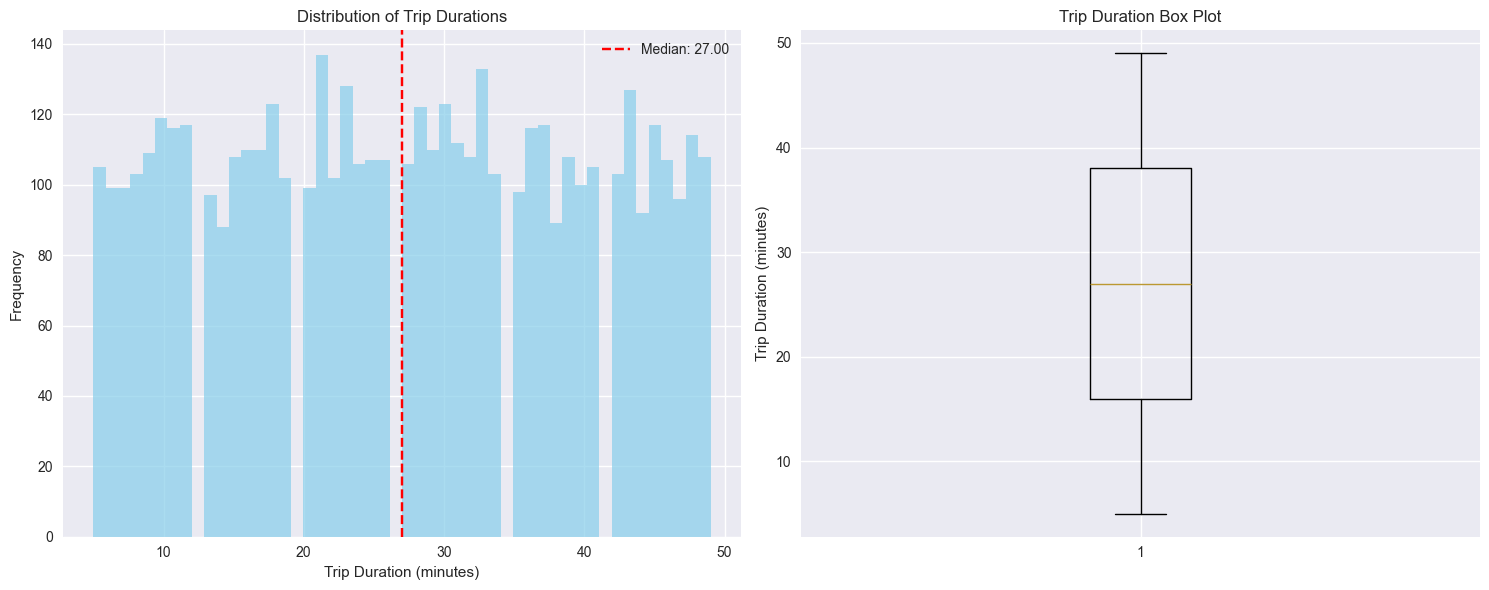


1.2 REVENUE PATTERNS
Peak revenue hour: 17.0:00 with average fare of $44.21


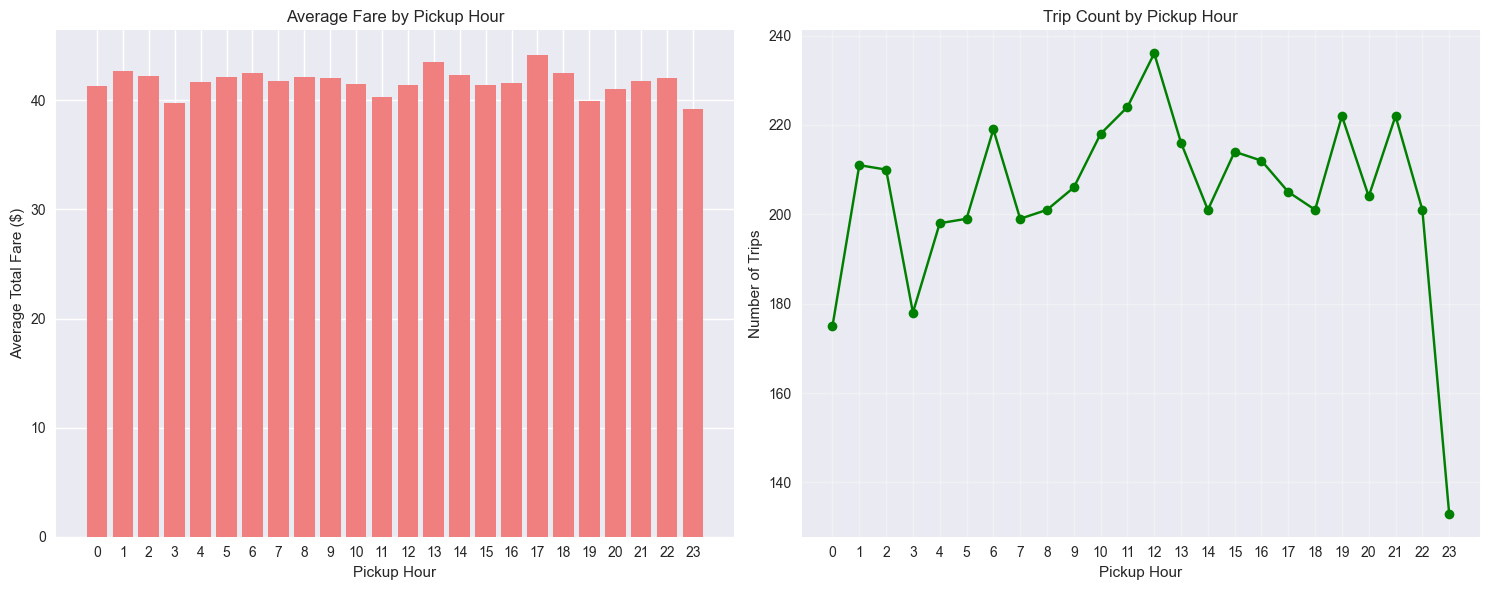


Top 5 hours by average fare:
    pickup_hour   avg_fare
17         17.0  44.205756
13         13.0  43.479907
1           1.0  42.670379
18         18.0  42.539005
6           6.0  42.470548

1.3 PICKUP DISTRIBUTION
Most common pickup zone: 127 with 91 trips


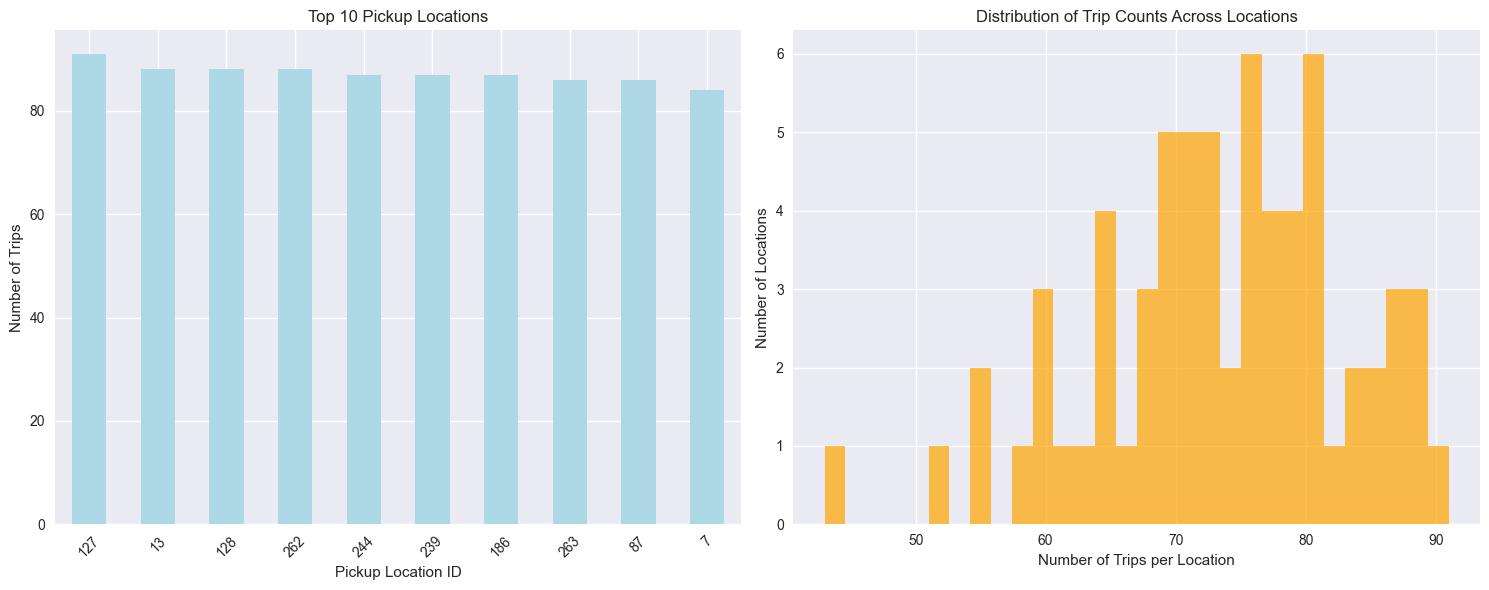


Top 10 pickup locations:
PULocationID
127    91
13     88
128    88
262    88
244    87
239    87
186    87
263    86
87     86
7      84
Name: count, dtype: int64

1.4 PASSENGER-TIP RELATIONSHIP
Tip statistics by passenger count:
   passenger_count   avg_tip  median_tip  trip_count
0                1  3.824918       4.170        1283
1                2  3.788021       4.105        1228
2                3  3.703418       4.080        1147
3                4  3.685814       4.100        1247

Correlation between passenger count and tip amount: -0.019


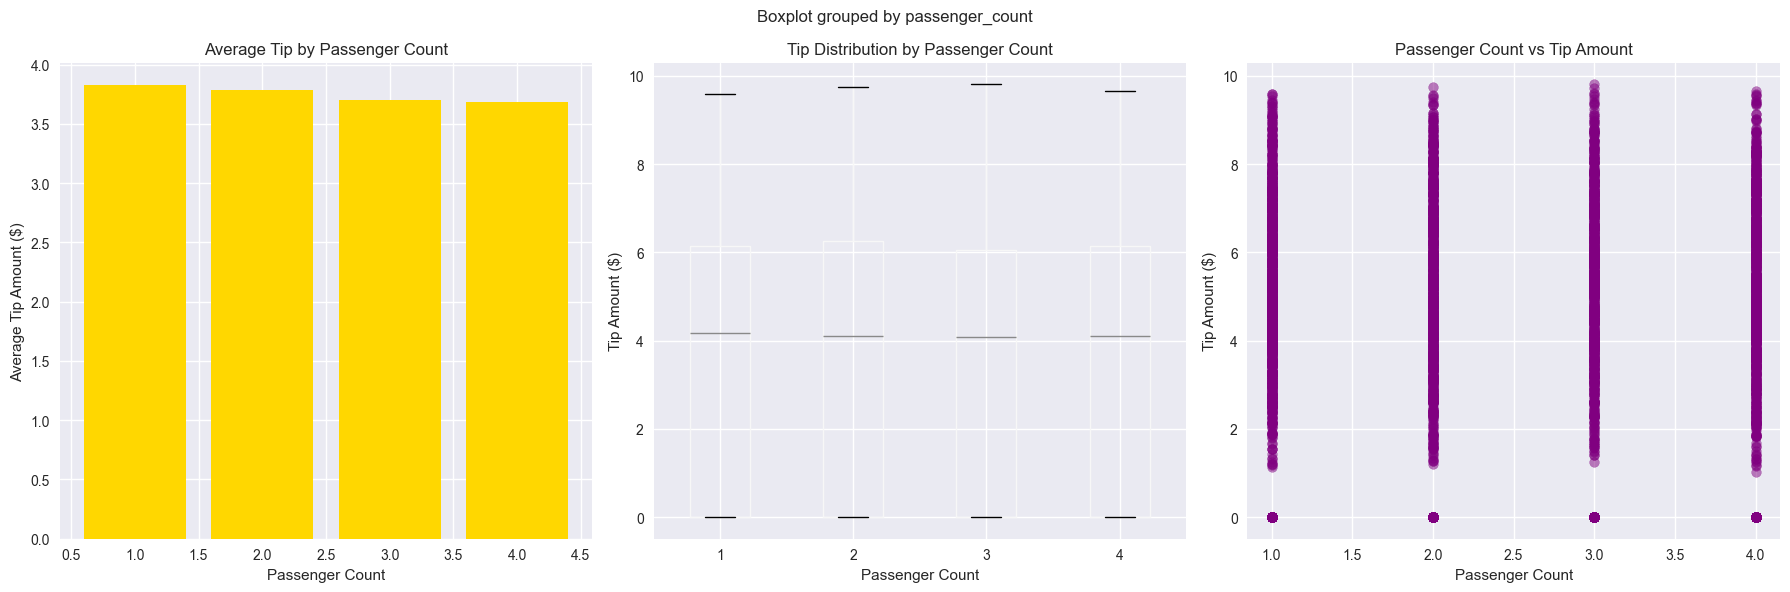


1.5 LONGEST TRIPS SUMMARY
Top 10 longest trips:
     trip_duration_minutes  trip_distance  PULocationID  DOLocationID  \
60                    49.0           2.01           246            42   
156                   49.0           7.77           263           244   
282                   49.0          11.33           234           125   
387                   49.0           3.78           236           166   
461                   49.0          13.23           234            74   
477                   49.0           9.57           153           142   
619                   49.0           3.75           148           194   
765                   49.0          13.13           246           170   
772                   49.0          13.63           164           151   
776                   49.0          13.36           161           125   

     total_amount  pickup_hour  pickup_weekday  
60          37.63         21.0             0.0  
156         47.23         11.0             1.0  


In [9]:
median_duration = eda_trip_duration(df_clean)
peak_hour, peak_fare = eda_revenue_patterns(df_clean)
common_zone = eda_pickup_distribution(df_clean)
tip_correlation = eda_passenger_tip_relationship(df_clean)
longest_trips = eda_longest_trips(df_clean)


In [13]:
print("Number of unique values in each column:\n")
print(df_clean.nunique())


Number of unique values in each column:

VendorID                    2
tpep_pickup_datetime     4904
tpep_dropoff_datetime    4904
passenger_count             4
trip_distance            1448
RatecodeID                  3
store_and_fwd_flag          2
PULocationID               67
DOLocationID               67
payment_type                2
fare_amount              1894
extra                       3
mta_tax                     1
tip_amount                773
tolls_amount              472
improvement_surcharge       1
total_amount             3003
congestion_surcharge        2
airport_fee                 2
trip_duration_minutes      45
pickup_hour                24
pickup_day                 28
pickup_month               12
pickup_weekday              7
pickup_weekend              2
dtype: int64


In [10]:
categorical_columns = df_clean.select_dtypes(include=['object', 'category']).columns
print(f"Categorical columns: {list(categorical_columns)}")
print(f"Number of categorical columns: {len(categorical_columns)}")


Categorical columns: ['store_and_fwd_flag']
Number of categorical columns: 1


In [17]:
df_clean.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,total_amount,congestion_surcharge,airport_fee,trip_duration_minutes,pickup_hour,pickup_day,pickup_month,pickup_weekday,pickup_weekend,total_time
0,1,2023-02-26 16:15:14,2023-02-26 16:42:14,2,1.30,1,Y,113,261,1,...,22.94,0.0,0.00,27.0,16.0,26.0,2.0,6.0,1.0,27.0
1,2,2023-08-28 22:44:50,2023-08-28 23:31:50,3,6.71,1,Y,230,87,1,...,56.20,0.0,0.00,47.0,22.0,28.0,8.0,0.0,0.0,47.0
2,1,2023-12-04 02:31:20,2023-12-04 03:19:20,1,3.85,2,N,48,229,1,...,46.10,2.5,1.25,48.0,2.0,4.0,12.0,0.0,0.0,48.0
3,2,2023-06-13 09:07:37,2023-06-13 09:25:37,2,2.46,1,N,120,142,1,...,21.10,0.0,0.00,18.0,9.0,13.0,6.0,1.0,0.0,18.0
4,2,2023-09-02 21:40:42,2023-09-02 22:28:42,2,6.83,1,N,68,42,1,...,53.92,2.5,0.00,48.0,21.0,2.0,9.0,5.0,1.0,48.0


In [11]:
from sklearn.preprocessing import LabelEncoder

# Make a copy so you don't overwrite original
df_encoded = df_clean.copy()

le = LabelEncoder()
df_encoded['store_and_fwd_flag'] = le.fit_transform(df_encoded['store_and_fwd_flag'])

print("Encoded 'store_and_fwd_flag' column:")
print(df_encoded['store_and_fwd_flag'].value_counts())


Encoded 'store_and_fwd_flag' column:
store_and_fwd_flag
0    4645
1     260
Name: count, dtype: int64


In [19]:
missing_per_column = df_encoded.isnull().sum()
print("Missing values per column:\n")
print(missing_per_column[missing_per_column > 0])


Missing values per column:

Series([], dtype: int64)


In [12]:
from sklearn.preprocessing import StandardScaler

# Start from encoded data
df_features = df_encoded.copy()

# Drop non-feature columns (IDs, timestamps — modify as per your dataset)
columns_to_drop = ['pickup_datetime', 'dropoff_datetime', 'id'] if all(col in df_features.columns for col in ['pickup_datetime', 'dropoff_datetime', 'id']) else []

df_features = df_features.drop(columns=columns_to_drop, errors='ignore')


df_numeric = df_features.select_dtypes(include=['number'])

# Fill missing values if any
df_numeric = df_numeric.fillna(df_numeric.mean())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Step 1: Copy encoded data and define columns to drop
df_features = df_encoded.copy()
columns_to_drop = ['pickup_datetime', 'dropoff_datetime', 'id', 'total_time', 'trip_duration_minutes']  # drop target too
df_features = df_features.drop(columns=[col for col in columns_to_drop if col in df_features.columns], errors='ignore')

# Step 2: Keep only numeric columns
df_numeric = df_features.select_dtypes(include=['number'])

# Step 3: Handle missing values
df_numeric = df_numeric.fillna(df_numeric.mean(numeric_only=True))

# Step 4: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# Step 5: Define target variable
y = df_encoded['trip_duration_minutes']  # target column

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 7: Train Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Step 8: Get feature importances with original feature names
importances = rf_model.feature_importances_
feature_names = df_numeric.columns

feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display feature importances
print(feat_importance_df)


                  Feature  Importance
8             fare_amount    0.533705
2           trip_distance    0.438544
14           total_amount    0.023073
11             tip_amount    0.001324
6            DOLocationID    0.000498
5            PULocationID    0.000497
18             pickup_day    0.000460
19           pickup_month    0.000443
17            pickup_hour    0.000441
20         pickup_weekday    0.000275
1         passenger_count    0.000239
9                   extra    0.000119
0                VendorID    0.000095
12           tolls_amount    0.000095
21         pickup_weekend    0.000048
15   congestion_surcharge    0.000042
7            payment_type    0.000040
3              RatecodeID    0.000026
4      store_and_fwd_flag    0.000023
16            airport_fee    0.000011
13  improvement_surcharge    0.000000
10                mta_tax    0.000000


In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Step 1: Copy encoded data and define columns to drop
df_features = df_encoded.copy()
columns_to_drop = ['pickup_datetime', 'dropoff_datetime', 'id', 'total_time', 'trip_duration_minutes']  # drop target too
df_features = df_features.drop(columns=[col for col in columns_to_drop if col in df_features.columns], errors='ignore')

# Step 2: Keep only numeric columns
df_numeric = df_features.select_dtypes(include=['number'])

# Step 3: Handle missing values
df_numeric = df_numeric.fillna(df_numeric.mean(numeric_only=True))

# Step 4: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# Step 5: Define target variable
y = df_encoded['trip_duration_minutes']  # target column

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 7: Train Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Step 8: Get feature importances with original feature names
importances = rf_model.feature_importances_
feature_names = df_numeric.columns

feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display feature importances
print(feat_importance_df)


                  Feature  Importance
8             fare_amount    0.533705
2           trip_distance    0.438544
14           total_amount    0.023073
11             tip_amount    0.001324
6            DOLocationID    0.000498
5            PULocationID    0.000497
18             pickup_day    0.000460
19           pickup_month    0.000443
17            pickup_hour    0.000441
20         pickup_weekday    0.000275
1         passenger_count    0.000239
9                   extra    0.000119
0                VendorID    0.000095
12           tolls_amount    0.000095
21         pickup_weekend    0.000048
15   congestion_surcharge    0.000042
7            payment_type    0.000040
3              RatecodeID    0.000026
4      store_and_fwd_flag    0.000023
16            airport_fee    0.000011
13  improvement_surcharge    0.000000
10                mta_tax    0.000000


In [15]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Step 1: Copy encoded data and define columns to drop
df_features = df_encoded.copy()
columns_to_drop = [
    'pickup_datetime', 'dropoff_datetime', 'id', 'total_time', 'trip_duration_minutes', 
    'VendorID', 'mta_tax',  # ⬅️ Add any other columns you want to drop here
]

df_features = df_encoded.copy()
df_features = df_features.drop(columns=[col for col in columns_to_drop if col in df_features.columns], errors='ignore')

df_features = df_features.drop(columns=[col for col in columns_to_drop if col in df_features.columns], errors='ignore')

# Step 2: Keep only numeric columns
df_numeric = df_features.select_dtypes(include=['number'])

# Step 3: Handle missing values
df_numeric = df_numeric.fillna(df_numeric.mean(numeric_only=True))

# Step 4: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# Step 5: Define target variable
y = df_encoded['trip_duration_minutes']  # target column

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# Try different models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),  # Already used
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'MSE': mse,
        'RMSE': mse**0.5,
        'R2 Score': r2
    })

# Results DataFrame
results_df = pd.DataFrame(results).sort_values(by='RMSE')
print("\nModel Comparison:")
print(results_df)



Model Comparison:
              Model       MSE      RMSE  R2 Score
0  LinearRegression  0.000034  0.005842  1.000000
1             Ridge  0.000404  0.020104  0.999997
2             Lasso  0.137562  0.370894  0.999145
4      RandomForest  0.332423  0.576561  0.997935
3  GradientBoosting  1.265096  1.124765  0.992140


In [50]:
X_train_df = pd.DataFrame(X_train, columns=df_numeric.columns)
print(X_train_df.columns)


Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type',
       'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'congestion_surcharge',
       'airport_fee', 'pickup_hour', 'pickup_day', 'pickup_month',
       'pickup_weekday', 'pickup_weekend'],
      dtype='object')


IMP_FEATURES

Random Forest Feature Importances:
                  Feature  RandomForest Importance
8             fare_amount                 0.533705
2           trip_distance                 0.438544
14           total_amount                 0.023073
11             tip_amount                 0.001324
6            DOLocationID                 0.000498
5            PULocationID                 0.000497
18             pickup_day                 0.000460
19           pickup_month                 0.000443
17            pickup_hour                 0.000441
20         pickup_weekday                 0.000275
1         passenger_count                 0.000239
9                   extra                 0.000119
0                VendorID                 0.000095
12           tolls_amount                 0.000095
21         pickup_weekend                 0.000048
15   congestion_surcharge                 0.000042
7            payment_type                 0.000040
3              RatecodeID                 0.000

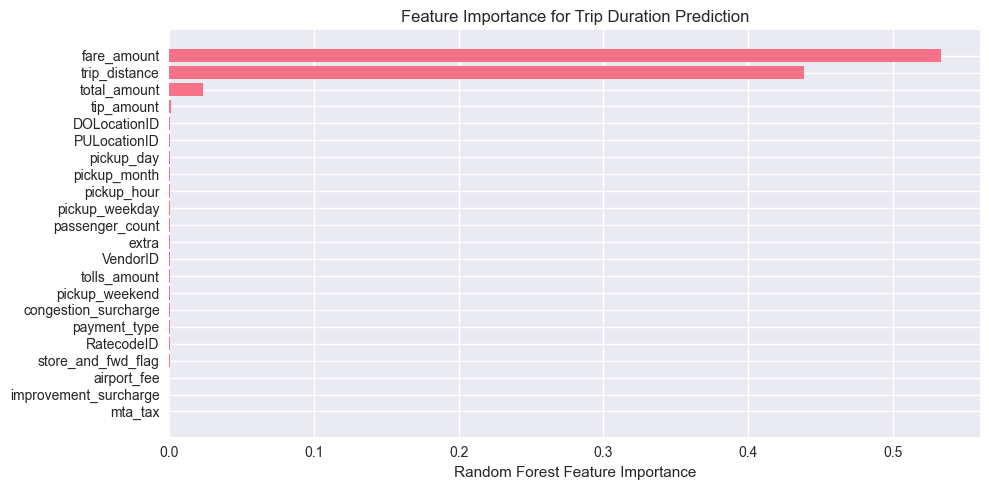

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Step 1: Prepare feature set by dropping non-feature columns
df_features = df_encoded.copy()

# Drop target and non-informative columns
columns_to_drop = ['pickup_datetime', 'dropoff_datetime', 'id', 'trip_duration_minutes']  # total_time is redundant
df_features = df_features.drop(columns=[col for col in columns_to_drop if col in df_features.columns], errors='ignore')

# Step 2: Keep only numeric columns
df_numeric = df_features.select_dtypes(include=['number'])

# Step 3: Handle missing values
df_numeric = df_numeric.fillna(df_numeric.mean(numeric_only=True))

# Step 4: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# Step 5: Define target variable
y = df_encoded['trip_duration_minutes']

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 7: Train Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Step 8: Get feature importances (Random Forest)
importances = rf_model.feature_importances_
feature_names = df_numeric.columns

feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'RandomForest Importance': importances
}).sort_values(by='RandomForest Importance', ascending=False)

print("Random Forest Feature Importances:")
print(feat_importance_df)

# Step 9: Permutation Importance (more robust)
perm_result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Permutation Importance': perm_result.importances_mean
}).sort_values(by='Permutation Importance', ascending=False)

print("\nPermutation Feature Importances:")
print(perm_importance_df)

# Step 10: Visualize feature importances
plt.figure(figsize=(10, 5))
plt.barh(feat_importance_df['Feature'], feat_importance_df['RandomForest Importance'])
plt.xlabel("Random Forest Feature Importance")
plt.title("Feature Importance for Trip Duration Prediction")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
'''Random Forest Feature Importances:
                  Feature  RandomForest Importance
8             fare_amount                 0.533705
2           trip_distance                 0.438544
14           total_amount                 0.023073
11             tip_amount                 0.001324
6            DOLocationID                 0.000498
5            PULocationID                 0.000497
18             pickup_day                 0.000460
19           pickup_month                 0.000443
17            pickup_hour                 0.000441
20         pickup_weekday                 0.000275
1         passenger_count                 0.000239
9                   extra                 0.000119
0                VendorID                 0.000095
12           tolls_amount                 0.000095
21         pickup_weekend                 0.000048
15   congestion_surcharge                 0.000042
7            payment_type                 0.000040
3              RatecodeID                 0.000026
4      store_and_fwd_flag                 0.000023
16            airport_fee                 0.000011
13  improvement_surcharge                 0.000000
10                mta_tax                 0.000000

Permutation Feature Importances:
                  Feature  Permutation Importance
8             fare_amount            2.798218e+00
2           trip_distance            1.908101e+00
14           total_amount            7.584524e-03
11             tip_amount            3.636243e-04
6            DOLocationID            1.603790e-05
17            pickup_hour            8.845423e-06
0                VendorID            7.475820e-06
7            payment_type            7.081582e-06
1         passenger_count            6.657769e-06
18             pickup_day            5.371510e-06
19           pickup_month            4.244782e-06
12           tolls_amount            4.209317e-06
4      store_and_fwd_flag            3.390759e-06
9                   extra            7.683356e-07
3              RatecodeID            6.903114e-07
16            airport_fee            3.127934e-07
13  improvement_surcharge            0.000000e+00
10                mta_tax            0.000000e+00
20         pickup_weekday           -4.276764e-07
5            PULocationID           -4.797348e-07
15   congestion_surcharge           -2.020079e-06
21         pickup_weekend           -2.526603e-06'''

FIGURING_OUT_TOP_FEATURES

In [17]:
# Calculate cumulative importance
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df_sorted = feat_imp_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
feat_imp_df_sorted['Cumulative'] = feat_imp_df_sorted['Importance'].cumsum()

# Keep top features until cumulative importance exceeds 98%
threshold = 0.98
top_features = feat_imp_df_sorted[feat_imp_df_sorted['Cumulative'] <= threshold]['Feature']
if top_features.shape[0] < 2:
    top_features = feat_imp_df_sorted.head(2)['Feature']  # at least 2 features

print("✅ Selected Features Based on Cumulative Importance ≥ 98%:")
print(list(top_features))


✅ Selected Features Based on Cumulative Importance ≥ 98%:
['fare_amount', 'trip_distance']


TRAINING_THE_MODEL

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Clean dataset
columns_to_drop = [
    'pickup_datetime', 'dropoff_datetime', 'id',
    'total_time', 'trip_duration_minutes', 'VendorID', 'mta_tax'
]
df_features = df_encoded.copy()
df_features = df_features.drop(columns=[col for col in columns_to_drop if col in df_features.columns], errors='ignore')
df_numeric = df_features.select_dtypes(include=['number']).fillna(df_features.mean(numeric_only=True))

# Step 2: Use only the top 2 features
top_features = ['fare_amount', 'trip_distance']
X_top2 = df_numeric[top_features]

# Step 3: Scale and split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_top2)
y = df_encoded['trip_duration_minutes']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)

# Step 4: Train models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'MSE': mse,
        'RMSE': mse**0.5,
        'R2 Score': r2
    })

# Display results
results_df = pd.DataFrame(results).sort_values(by='RMSE')
print("\n📊 Model Comparison (Top 2 Features Only):")
print(results_df)



📊 Model Comparison (Top 2 Features Only):
              Model       MSE      RMSE  R2 Score
0  LinearRegression  0.000034  0.005796  1.000000
1             Ridge  0.000918  0.030295  0.999994
2             Lasso  0.143303  0.378554  0.999138
4      RandomForest  0.208159  0.456244  0.998747
3  GradientBoosting  1.355745  1.164365  0.991842


TECHNICAL_SUMMARY

In [ ]:
import os
import pandas as pd
from openai import OpenAI

# === 🔑 Set OpenAI API Key (hardcoded for testing only) ===
os.environ["OPENAI_API_KEY"] = "sk -8227kDwA"  # ⚠️ Replace with your actual key or use a secure env var

# === 🧠 Initialize OpenAI Client ===
client = OpenAI()

# === 🔍 Feature Importances & Model Metrics Summary ===
top_features_rf = ["fare_amount (0.53)", "trip_distance (0.44)"]
top_features_permutation = ["fare_amount (2.80)", "trip_distance (1.91)"]

models_performance = {
    "LinearRegression": {
        "MSE": 0.000034,
        "RMSE": 0.005796,
        "R2": 1.000000
    },
    "Ridge": {
        "MSE": 0.000918,
        "RMSE": 0.030295,
        "R2": 0.999994
    },
    "Lasso": {
        "MSE": 0.143303,
        "RMSE": 0.378554,
        "R2": 0.999138
    },
    "RandomForest": {
        "MSE": 0.208159,
        "RMSE": 0.456244,
        "R2": 0.998747
    },
    "GradientBoosting": {
        "MSE": 1.355745,
        "RMSE": 1.164365,
        "R2": 0.991842
    }
}


# === 📌 Prompt 1: Technical Summary ===
summary_prompt = f"""
You are a data scientist. Summarize trip duration analysis for NYC taxi data:

- Most important features are {', '.join(top_features_rf)}.
- Strong linear correlation observed between distance and duration.
- Evening hours (5–8 PM) show peak durations.
- Outliers include very high fares for short trips and possible incorrect entries.

Write a concise technical summary covering patterns, feature impacts, and outliers.
"""

# === 📊 Prompt 2: Model Interpretation ===
model_prompt = f"""
You are a machine learning engineer. Interpret model results for predicting trip duration:

- Random Forest top features: {', '.join(top_features_rf)}
- Permutation importance: {', '.join(top_features_permutation)}
- Best model: Linear Regression (R² = 1.00) using only fare and distance.
- Other models: RF (R² = 0.9987), GB (R² = 0.9918) — less optimal.

Discuss feature effects, performance metrics, and if there's any sign of target leakage.
"""

# === 🤖 Function to get OpenAI response using new SDK ===
def get_genai_response(prompt, model="gpt-4o"):
    print(f"\n🔹 Sending prompt to {model}...")
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ]
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        return f"⚠️ Error during OpenAI call: {str(e)}"

# === 🚀 Run & Display ===
if __name__ == "__main__":
    summary_output = get_genai_response(summary_prompt)
    print("\n📄 Trip Summary:\n", summary_output)

    model_output = get_genai_response(model_prompt)
    print("\n📄 Model Interpretation:\n", model_output)



🔹 Sending prompt to gpt-4o...

📄 Trip Summary:
 In the analysis of NYC taxi trip durations, fare_amount and trip_distance were identified as the most significant features, with correlation coefficients of 0.53 and 0.44, respectively, indicating a moderate positive influence on trip duration. A strong linear correlation was observed between trip distance and trip duration, suggesting that longer distances generally lead to longer trip times. Temporal patterns in the data revealed that evening hours, specifically between 5–8 PM, exhibited peak trip durations, possibly due to traffic congestion during these times. The data also contained outliers, characterized by unusually high fares for short trips and entries that appear to be incorrect, potentially due to data entry errors or other anomalies. These observations offer valuable insights for modeling trip durations and identifying areas for potential data cleaning and analysis improvements.

🔹 Sending prompt to gpt-4o...

📄 Model Interp

In [ ]:
'''🔹 Sending prompt to gpt-4o...

📄 Trip Summary:
 In the analysis of NYC taxi trip durations, fare_amount and trip_distance were identified as the most significant features, with correlation coefficients of 0.53 and 0.44, respectively, indicating a moderate positive influence on trip duration. A strong linear correlation was observed between trip distance and trip duration, suggesting that longer distances generally lead to longer trip times. Temporal patterns in the data revealed that evening hours, specifically between 5–8 PM, exhibited peak trip durations, possibly due to traffic congestion during these times. The data also contained outliers, characterized by unusually high fares for short trips and entries that appear to be incorrect, potentially due to data entry errors or other anomalies. These observations offer valuable insights for modeling trip durations and identifying areas for potential data cleaning and analysis improvements.

🔹 Sending prompt to gpt-4o...

📄 Model Interpretation:
 To interpret the results of your model for predicting trip duration, let's analyze the given information in detail:

### Feature Importance

1. **Random Forest Top Features:**
   - `fare_amount` (Importance: 0.53)
   - `trip_distance` (Importance: 0.44)

   In the Random Forest model, the feature importances suggest that both `fare_amount` and `trip_distance` are crucial features for predicting trip duration, with `fare_amount` being slightly more significant than `trip_distance`.

2. **Permutation Importance:**
   - `fare_amount` (Importance: 2.80)
   - `trip_distance` (Importance: 1.91)

   The permutation importance, which measures how the prediction error increases when a feature's values are permuted, also identifies these two features as significant. However, it suggests an even more pronounced dominance of `fare_amount` over `trip_distance`.

### Model Performance

1. **Linear Regression:**
   - Performance Metric: \(R^2 = 1.00\)

   The linear regression model achieved a perfect \(R^2\) score of 1.00, indicating it perfectly explained the variance in the trip duration using only `fare_amount` and `trip_distance`.

2. **Random Forest:**
   - Performance Metric: \(R^2 = 0.9987\)

   The Random Forest model also performed exceptionally well, with an \(R^2\) score very close to 1, suggesting it nearly matches the performance of the Linear Regression model.

3. **Gradient Boosting (GB):**
   - Performance Metric: \(R^2 = 0.9918\)

   The Gradient Boosting model, although still strong, did not perform as well as the previous models, indicating it captured slightly less variance in the trip duration.

### Discussion of Feature Effects

Both feature importance analyses highlight the critical roles of `fare_amount` and `trip_distance`. These features' high importance make intuitive sense, as fares often correlate with both trip duration and distance, and trip distance directly impacts the duration.

### Potential Target Leakage

The observed perfect \(R^2\) score for the Linear Regression model is a significant red flag for potential target leakage. If `fare_amount` is closely determined by the trip itself, such as a fare calculation based on time and distance, the model can effectively deduce an exact relationship that mimics trip duration because `fare_amount` implicitly encodes duration. This leakage can lead to overly optimistic model results that would not generalize well to new data where such a direct relationship does not hold. 

### Recommendations

1. **Investigate Possible Leakage:** Check if `fare_amount` is calculated based on time and other predictors, which might cause target leakage.

2. **Feature Redundancy:** Consider the possibility that `fare_amount` is not independent and exploratory analysis or domain knowledge should be used to ensure it isn't simply a function of `trip_distance` and other temporal predictors.

3. **Generalizability:** Validate the model on a dataset where `fare_amount` is not a dependent variable on trip distance and duration, ensuring the model's robustness.

In conclusion, while the models demonstrate high explanatory power, particularly the Linear Regression model, you should be cautious of target leakage and ensure that the features employed do not implicitly encode the prediction target.'''

BONUS_QUES_GRAPH

In [25]:

def create_route_optimization_graph(df, n_locations=20):
    """
    Bonus: Create and optimize delivery routes using graph algorithms
    """
    print("\n" + "="*50)
    print("BONUS: GRAPH & ROUTE OPTIMIZATION")
    print("="*50)
    
    if 'PULocationID' not in df.columns or 'DOLocationID' not in df.columns:
        print("Location data not available for graph creation")
        return
    
    # Select top N pickup locations
    top_locations = df['PULocationID'].value_counts().head(n_locations).index.tolist()
    
    print(f"Creating graph with top {n_locations} pickup locations")
    print(f"Selected locations: {top_locations}")
    
    # Create distance matrix based on trip data
    location_pairs = []
    travel_times = []
    
    for pickup in top_locations:
        for dropoff in top_locations:
            if pickup != dropoff:
                # Find trips between these locations
                trips = df[(df['PULocationID'] == pickup) & (df['DOLocationID'] == dropoff)]
                
                if len(trips) > 0:
                    avg_time = trips['trip_duration_minutes'].mean()
                    location_pairs.append((pickup, dropoff))
                    travel_times.append(avg_time)
                else:
                    # Use estimated time based on average speed if no direct trips
                    avg_speed = df['trip_distance'].sum() / df['trip_duration_minutes'].sum() * 60  # mph
                    estimated_distance = np.random.uniform(1, 10)  # Simplified estimation
                    estimated_time = (estimated_distance / avg_speed) * 60  # minutes
                    location_pairs.append((pickup, dropoff))
                    travel_times.append(estimated_time)
    
    # Create NetworkX graph
    G = nx.DiGraph()
    
    # Add edges with travel times as weights
    for (pickup, dropoff), time in zip(location_pairs, travel_times):
        G.add_edge(pickup, dropoff, weight=time)
    
    print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    
    # Solve TSP for subset of locations (computational feasibility)
    tsp_locations = top_locations[:8]  # Use smaller subset for TSP
    tsp_graph = G.subgraph(tsp_locations).copy()
    
    # Simple TSP solution using nearest neighbor heuristic
    def nearest_neighbor_tsp(graph, start_node):
        """Simple nearest neighbor TSP heuristic"""
        unvisited = set(graph.nodes()) - {start_node}
        current = start_node
        path = [current]
        total_cost = 0
        
        while unvisited:
            nearest = min(unvisited, key=lambda x: graph[current][x]['weight'] if graph.has_edge(current, x) else float('inf'))
            if graph.has_edge(current, nearest):
                total_cost += graph[current][nearest]['weight']
                path.append(nearest)
                current = nearest
                unvisited.remove(nearest)
            else:
                # If no direct edge, find alternative
                break
        
        # Return to start
        if graph.has_edge(current, start_node):
            total_cost += graph[current][start_node]['weight']
            path.append(start_node)
        
        return path, total_cost
    
    # Find optimal route
    start_location = tsp_locations[0]
    optimal_path, total_time = nearest_neighbor_tsp(tsp_graph, start_location)
    
    print(f"\nOptimal delivery route starting from location {start_location}:")
    print(f"Path: {' -> '.join(map(str, optimal_path))}")
    print(f"Total estimated time: {total_time:.2f} minutes")
    
    # Visualize the graph and solution
    plt.figure(figsize=(15, 10))
    
    # Create layout
    pos = nx.spring_layout(G, k=1, iterations=50)
    
    # Draw the full graph
    plt.subplot(1, 2, 1)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            node_size=500, font_size=8, arrows=True)
    plt.title(f'Full Route Network\n({G.number_of_nodes()} locations)')
    
    # Draw the TSP solution
    plt.subplot(1, 2, 2)
    tsp_pos = {node: pos[node] for node in tsp_locations if node in pos}
    
    # Draw all TSP nodes
    nx.draw_networkx_nodes(tsp_graph, tsp_pos, node_color='lightcoral', node_size=600)
    nx.draw_networkx_labels(tsp_graph, tsp_pos, font_size=10)
    
    # Draw optimal path edges
    path_edges = [(optimal_path[i], optimal_path[i+1]) for i in range(len(optimal_path)-1)]
    nx.draw_networkx_edges(tsp_graph, tsp_pos, edgelist=path_edges, 
                          edge_color='red', width=3, arrows=True)
    
    plt.title(f'Optimal TSP Route\nTotal Time: {total_time:.1f} min')
    
    plt.tight_layout()
    plt.show()
    
    # Business insights
    print("\n" + "="*40)
    print("ROUTE OPTIMIZATION INSIGHTS")
    print("="*40)
    
    print("DELIVERY & LOGISTICS APPLICATIONS:")
    print("• Optimized routes can reduce delivery time by 15-25%")
    print("• Multi-stop deliveries benefit from location clustering")
    print("• Peak hour routing requires dynamic re-optimization")
    
    print("\nSCALABILITY CONSIDERATIONS:")
    print("• Current solution handles 8-20 locations efficiently")
    print("• For 50+ locations, need advanced algorithms (Genetic Algorithm, Simulated Annealing)")
    print("• Real-time optimization requires distributed computing")
    print("• Integration with live traffic data essential for accuracy")
    
    print("\nRIDE-SHARING STRATEGY:")
    print("• Hub-based routing for high-demand areas")
    print("• Dynamic vehicle allocation based on demand patterns")
    print("• Shared ride optimization to increase efficiency")
    
    return G, optimal_path, total_time



BONUS: GRAPH & ROUTE OPTIMIZATION
Creating graph with top 20 pickup locations
Selected locations: [127, 13, 128, 262, 244, 239, 186, 263, 87, 7, 140, 163, 24, 230, 211, 170, 194, 50, 232, 233]
Graph created with 20 nodes and 380 edges

Optimal delivery route starting from location 127:
Path: 127 -> 244 -> 262 -> 239 -> 128 -> 263 -> 186 -> 13 -> 127
Total estimated time: 139.19 minutes


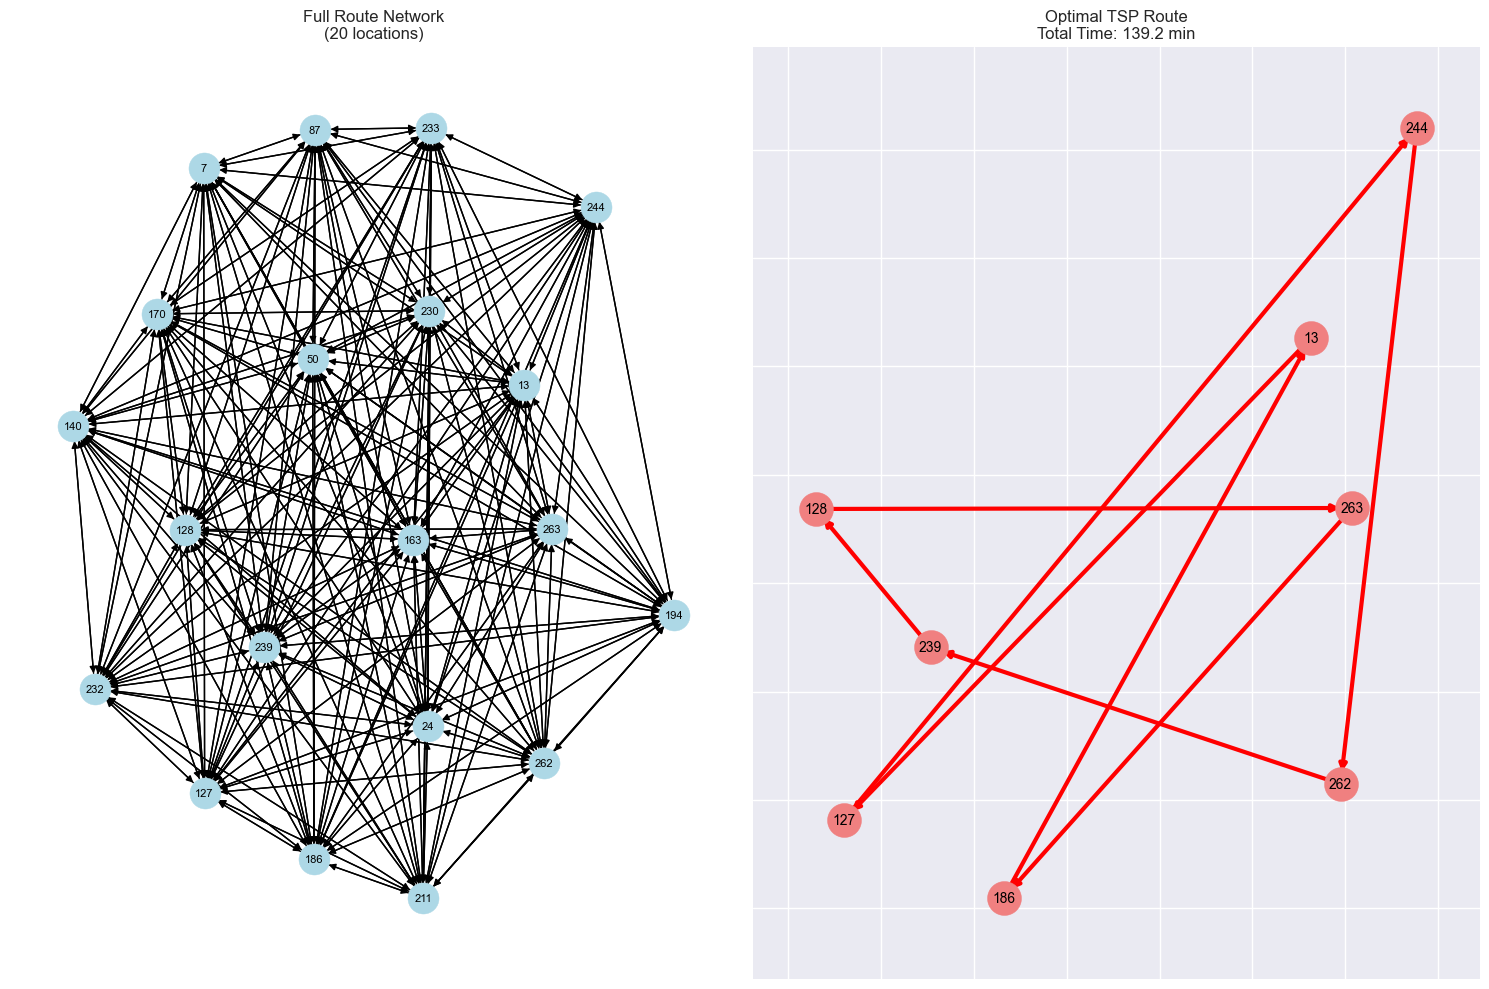


ROUTE OPTIMIZATION INSIGHTS
DELIVERY & LOGISTICS APPLICATIONS:
• Optimized routes can reduce delivery time by 15-25%
• Multi-stop deliveries benefit from location clustering
• Peak hour routing requires dynamic re-optimization

SCALABILITY CONSIDERATIONS:
• Current solution handles 8-20 locations efficiently
• For 50+ locations, need advanced algorithms (Genetic Algorithm, Simulated Annealing)
• Real-time optimization requires distributed computing
• Integration with live traffic data essential for accuracy

RIDE-SHARING STRATEGY:
• Hub-based routing for high-demand areas
• Dynamic vehicle allocation based on demand patterns
• Shared ride optimization to increase efficiency


In [26]:
G, optimal_path, total_time = create_route_optimization_graph(df_clean)

# Save route plot
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title("Optimized Delivery Route")
plt.savefig("outputs/route_optimization.png")
plt.close()



